In [119]:
import os
import pandas as pd
import numpy as np
from typing import List, Tuple, Optional

from scipy.signal import butter, sosfiltfilt, iirnotch, filtfilt


In [120]:
# path to folder that holds participant data
data_path = "C:/Users/nicho/Desktop/Nick-Weiss-CSC-Thesis-2526/data"

# get all the folders inside data directory that hold individual trials
participant_folders = [
    entry for entry in os.listdir(data_path) 
    if os.path.isdir(os.path.join(data_path, entry))
]

# keep list of all dataframes
dfs = []

# folder name is the participant id
# ****MIGHT CHANGE THE FORMAT OF THE FOLDER LATER --> COME BACK TO THIS****
for participant_id in participant_folders:
    # get the path to the finalized data file
    csv_path = os.path.join(
        data_path, 
        participant_id, 
        "labeled.csv"
    )
    
    # print error if csv not found
    if not os.path.exists(csv_path):
        print(f"Skipping Participant {participant_id}: labeled.csv not found in {os.path.join(data_path, participant_id)}" )
    else:
        # read csv into dataframe
        participant_df = pd.read_csv(csv_path)

        # add participant id column and append to list
        participant_df['participant_id'] = participant_id
        dfs.append(participant_df)


Skipping Participant pilot_full: labeled.csv not found in C:/Users/nicho/Desktop/Nick-Weiss-CSC-Thesis-2526/data\pilot_full


In [121]:
def estimate_fs_from_time(df: pd.DataFrame) -> float:
    time_col = "Time (s)"
    t = pd.to_numeric(df[time_col], errors="coerce").to_numpy(dtype=float)
    t = t[~np.isnan(t)]
    dt = np.diff(t)
    dt = dt[dt > 0]
    if dt.size == 0:
        raise ValueError("Cannot estimate fs: no positive time differences.")
    fs = 1.0 / np.median(dt)
    return float(fs)


In [122]:
# handle missing values --> important so filters dont explode when they hit NaN
def col_to_float_with_small_gap_fill(series: pd.Series) -> np.ndarray:
    x = pd.to_numeric(series, errors="coerce").astype(float)
    x = x.interpolate(method="linear", limit_direction="both")
    return x.to_numpy()

# high-pass filter to remove drift
def highpass_filter(x: np.ndarray, fs: float, cutoff_hz: float = 20.0, order: int = 2) -> np.ndarray:
    nyq = 0.5 * fs
    sos = butter(order, cutoff_hz / nyq, btype="highpass", output="sos")
    # sosfiltfilt applies the filter foward and backward, giving zero phase shift (envelope timing must match video labels)
    return sosfiltfilt(sos, x)

# notch filter 60Hz and 120Hz power line interference
def notch_filter(x: np.ndarray, fs: float, freq_hz: float, q: float = 35.0) -> np.ndarray:
    nyq = 0.5 * fs
    if freq_hz >= nyq:
        return x  # can't notch above Nyquist
    w0 = freq_hz / nyq
    b, a = iirnotch(w0, q)
    return filtfilt(b, a, x)

# band pass filter (keep EMG band)
def bandpass_filter(x: np.ndarray, fs: float, low_hz: float = 20.0, high_hz: float = 450.0, order: int = 4) -> np.ndarray:
    nyq = 0.5 * fs
    high_hz = min(high_hz, 0.99 * nyq)
    sos = butter(order, [low_hz / nyq, high_hz / nyq], btype="bandpass", output="sos")
    return sosfiltfilt(sos, x)

# rectify
def rectify(x: np.ndarray) -> np.ndarray:
    return np.abs(x)

# low-pass filter
def lowpass_filter(x: np.ndarray, fs: float, cutoff_hz: float = 5.0, order: int = 4) -> np.ndarray:
    nyq = 0.5 * fs
    sos = butter(order, cutoff_hz / nyq, btype="lowpass", output="sos")
    return sosfiltfilt(sos, x)

# get emg envelope (low-pass and rectified)
def emg_envelope(x_bandpassed: np.ndarray, fs: float, envelope_lp_hz: float = 5.0) -> np.ndarray:
    x_rect = rectify(x_bandpassed)
    env = lowpass_filter(x_rect, fs=fs, cutoff_hz=envelope_lp_hz, order=4)
    return env

In [123]:
def add_emg_features(
    df: pd.DataFrame,
    emg_columns: list[str],
    fs: float,
    hp_hz: float = 20.0,
    notch_freqs: tuple[float, ...] = (60.0, 120.0),
    bp_low_hz: float = 20.0,
    bp_high_hz: float = 450.0,
    env_lp_hz: float = 5.0,
) -> pd.DataFrame:
    out = df.copy()
    

    # want to apply feature engineering to all emg columns
    for col in emg_columns:
        if col  in out.columns:      
            # interpolate missing values
            x = col_to_float_with_small_gap_fill(out[col])

            # apply high pass filter
            x = highpass_filter(x, fs=fs, cutoff_hz=hp_hz, order=2)

            # apply notch filters
            for f0 in notch_freqs:
                x = notch_filter(x, fs=fs, freq_hz=f0, q=35.0)

            # apply bandpass filter
            x_bp = bandpass_filter(x, fs=fs, low_hz=bp_low_hz, high_hz=bp_high_hz, order=4)

            # envelope emg
            env = emg_envelope(x_bp, fs=fs, envelope_lp_hz=env_lp_hz)

            out[f"{col}_FILTERED"] = x_bp
            out[f"{col}_ENV"] = env

    return out

In [124]:
import numpy as np
import pandas as pd

def add_accel_features(
    df: pd.DataFrame,
    sensor_ids: list[str],
    fs: float,
    accel_denoise_lowpass_hz: float = 20.0,   # removes sensor noise
    gravity_lowpass_hz: float = 0.5,          # gravity / orientation estimate
    keep_gravity: bool = True,               # set True if you want *_GRAV columns
) -> pd.DataFrame:
    """
    Feature engineering:
    - *_DENOISED : low-pass denoised accel (motion + gravity)
    - *_DYN      : gravity-removed dynamic accel
    - AccelMag_DYN : magnitude of dynamic accel (orientation-robust)

    Suitable for both windowed ML and deep learning pipelines.
    """
    out = df.copy()

    for sid in sensor_ids:
        ax = f"{sid}_AccelX"
        ay = f"{sid}_AccelY"
        az = f"{sid}_AccelZ"

        if not all(c in out.columns for c in [ax, ay, az]):
            continue

        for col in [ax, ay, az]:
            x = col_to_float_with_small_gap_fill(out[col])

            # 1) Denoise (keeps all human motion + gravity)
            x_denoised = lowpass_filter(
                x, fs=fs, cutoff_hz=accel_denoise_lowpass_hz, order=4
            )

            # 2) Gravity / orientation estimate (very low frequency)
            x_grav = lowpass_filter(
                x_denoised, fs=fs, cutoff_hz=gravity_lowpass_hz, order=2
            )

            # 3) Dynamic acceleration (gravity removed)
            x_dyn = x_denoised - x_grav

            out[f"{col}_DENOISED"] = x_denoised
            out[f"{col}_DYN"] = x_dyn

            if keep_gravity:
                out[f"{col}_GRAV"] = x_grav

        # Dynamic acceleration magnitude (main accel feature)
        out[f"{sid}_AccelMag_DYN"] = np.sqrt(
            out[f"{ax}_DYN"]**2 + out[f"{ay}_DYN"]**2 + out[f"{az}_DYN"]**2
        )

        # Optional: denoised magnitude (mostly for visualization / sanity checks)
        out[f"{sid}_AccelMag_DENOISED"] = np.sqrt(
            out[f"{ax}_DENOISED"]**2 +
            out[f"{ay}_DENOISED"]**2 +
            out[f"{az}_DENOISED"]**2
        )

    return out


In [125]:
def add_gyro_features(
    df: pd.DataFrame,
    sensor_ids: list[str],
    fs: float,
    gyro_denoise_lowpass_hz: float = 20.0,  # denoise / band-limit
    gyro_bias_lowpass_hz: float = 0.2,      # slow drift estimate
    keep_bias: bool = True,               # True if you want *_BIAS columns for plots
) -> pd.DataFrame:
    """
    Gyro feature engineering (DL-friendly time-series columns):
    - *_DENOISED : low-pass filtered angular velocity (removes HF noise)
    - *_BIAS     : very low-frequency component (gyro drift / slow offset) [optional]
    - *_DYN      : denoised - bias (removes slow drift)
    - GyroMag_DENOISED, GyroMag_DYN : rotation intensity (axis-independent)
    """
    out = df.copy()

    for sid in sensor_ids:
        gx = f"{sid}_GyroX"
        gy = f"{sid}_GyroY"
        gz = f"{sid}_GyroZ"

        if not all(c in out.columns for c in [gx, gy, gz]):
            continue

        for col in [gx, gy, gz]:
            x = col_to_float_with_small_gap_fill(out[col])

            x_denoised = lowpass_filter(x, fs=fs, cutoff_hz=gyro_denoise_lowpass_hz, order=4)
            x_bias     = lowpass_filter(x_denoised, fs=fs, cutoff_hz=gyro_bias_lowpass_hz, order=2)
            x_dyn      = x_denoised - x_bias

            out[f"{col}_DENOISED"] = x_denoised
            out[f"{col}_DYN"]      = x_dyn
            if keep_bias:
                out[f"{col}_BIAS"] = x_bias

        # axis-independent rotation intensity
        out[f"{sid}_GyroMag_DENOISED"] = np.sqrt(
            out[f"{gx}_DENOISED"]**2 + out[f"{gy}_DENOISED"]**2 + out[f"{gz}_DENOISED"]**2
        )
        out[f"{sid}_GyroMag_DYN"] = np.sqrt(
            out[f"{gx}_DYN"]**2 + out[f"{gy}_DYN"]**2 + out[f"{gz}_DYN"]**2
        )

        # optional raw magnitude (sanity check)
        out[f"{sid}_GyroMag"] = np.sqrt(out[gx]**2 + out[gy]**2 + out[gz]**2)

    return out


In [126]:
import numpy as np
import pandas as pd

def add_mag_features(
    df: pd.DataFrame,
    sensor_ids: list[str],
    fs: float,
    mag_denoise_lowpass_hz: float = 10.0,
) -> pd.DataFrame:
    """
    Magnetometer feature engineering:
    - *_DENOISED : low-pass filtered magnetometer signal (noise reduction)
    - MagnetMag_DENOISED : magnitude of denoised magnetic field vector

    Magnetometer features are primarily used for orientation/context and visualization.
    """
    out = df.copy()

    for sid in sensor_ids:
        mx = f"{sid}_MagX"
        my = f"{sid}_MagY"
        mz = f"{sid}_MagZ"

        if not all(c in out.columns for c in [mx, my, mz]):
            continue

        # denoise each axis
        for col in [mx, my, mz]:
            x = col_to_float_with_small_gap_fill(out[col])
            x_denoised = lowpass_filter(
                x, fs=fs, cutoff_hz=mag_denoise_lowpass_hz, order=4
            )
            out[f"{col}_DENOISED"] = x_denoised

        # magnitude of denoised magnetic field
        out[f"{sid}_MagnetMag_DENOISED"] = np.sqrt(
            out[f"{mx}_DENOISED"]**2 +
            out[f"{my}_DENOISED"]**2 +
            out[f"{mz}_DENOISED"]**2
        )

        # optional raw magnitude (sanity check / visualization)
        out[f"{sid}_MagnetMag"] = np.sqrt(
            out[mx]**2 + out[my]**2 + out[mz]**2
        )

    return out


In [127]:
sensor_ids = ["A5F2", "A19E"]


emg_cols = []
for id in sensor_ids:
    emg_cols.append(f"{id}_EMG1")
    emg_cols.append(f"{id}_EMG2")


for i in range(len(dfs)):
    df = dfs[i]
    # get sampling rate
    fs = estimate_fs_from_time(df)
    df = add_emg_features(df, emg_cols, fs)
    df = add_accel_features(df, sensor_ids, fs)
    df = add_gyro_features(df, sensor_ids, fs)
    df = add_mag_features(df, sensor_ids, fs)
    dfs[i] = df

full_df = pd.concat(dfs, ignore_index=True)

In [147]:
primitive_colors = {
    "Idle":       "#DDDDDD",
    "Reach":      "#A6CEE3",
    "Reposition": "#B2DF8A",
    "Transport":  "#FB9A99",
    "Stabilize":  "#FDBF6F",
}

In [149]:
from matplotlib.patches import Patch
import matplotlib.pyplot as plt

def shade_primitives(ax, t, primitives, color_map, alpha=0.25):
    """Background shading by contiguous primitive segments."""
    if len(t) == 0 or len(primitives) == 0:
        return

    # ensure positional alignment
    t = t.reset_index(drop=True)
    primitives = primitives.reset_index(drop=True)

    start_idx = 0
    current_prim = primitives.iloc[0]

    for i in range(1, len(primitives)):
        if primitives.iloc[i] != current_prim:
            ax.axvspan(
                t.iloc[start_idx],
                t.iloc[i - 1],
                color=color_map.get(current_prim, "gray"),
                alpha=alpha,
                linewidth=0,
            )
            start_idx = i
            current_prim = primitives.iloc[i]

    ax.axvspan(
        t.iloc[start_idx],
        t.iloc[-1],
        color=color_map.get(current_prim, "gray"),
        alpha=alpha,
        linewidth=0,
    )


def plot_signals_with_primitives(
    df,
    panels,
    *,
    time_col="Time (s)",
    primitive_col="Primitive",
    primitive_colors=None,
    t_start=0.0,
    t_end=10.0,
    figsize=(15, 9),
    y_label="",
    add_legend=True,
    savepath=None,
):
    """
    panels: list of dicts like:
      {"col": "<column name>", "title": "<plot title>"}

    Makes a multi-panel time-series plot over [t_start, t_end] with primitive shading.
    """
    if primitive_colors is None:
        primitive_colors = {}

    # slice + reset index so t/prims always align
    df_slice = df[(df[time_col] >= t_start) & (df[time_col] <= t_end)].reset_index(drop=True)
    if len(df_slice) == 0:
        raise ValueError("df_slice is empty for the chosen time range.")

    t = df_slice[time_col]
    prims = df_slice[primitive_col].astype(str).str.strip()

    fig, axes = plt.subplots(
        nrows=len(panels), ncols=1,
        figsize=figsize,
        sharex=True
    )
    if len(panels) == 1:
        axes = [axes]

    # legend (only primitives that appear in this slice)
    if add_legend and primitive_colors:
        present = set(prims.unique())
        legend_patches = [
            Patch(facecolor=primitive_colors[p], label=p, alpha=0.4)
            for p in primitive_colors.keys()
            if p in present
        ]
        if legend_patches:
            axes[0].legend(handles=legend_patches, loc="upper right")

    # plot panels
    for ax, spec in zip(axes, panels):
        col = spec["col"]
        title = spec.get("title", col)

        ax.plot(t, df_slice[col])
        ax.set_title(title)
        ax.set_ylabel(y_label)
        ax.grid(True, alpha=0.3)

        if primitive_colors:
            shade_primitives(ax, t, prims, primitive_colors)

    axes[-1].set_xlabel("Time (s)")
    plt.tight_layout()

    if savepath is not None:
        plt.savefig(savepath, dpi=300)

    plt.show()
    return fig, axes


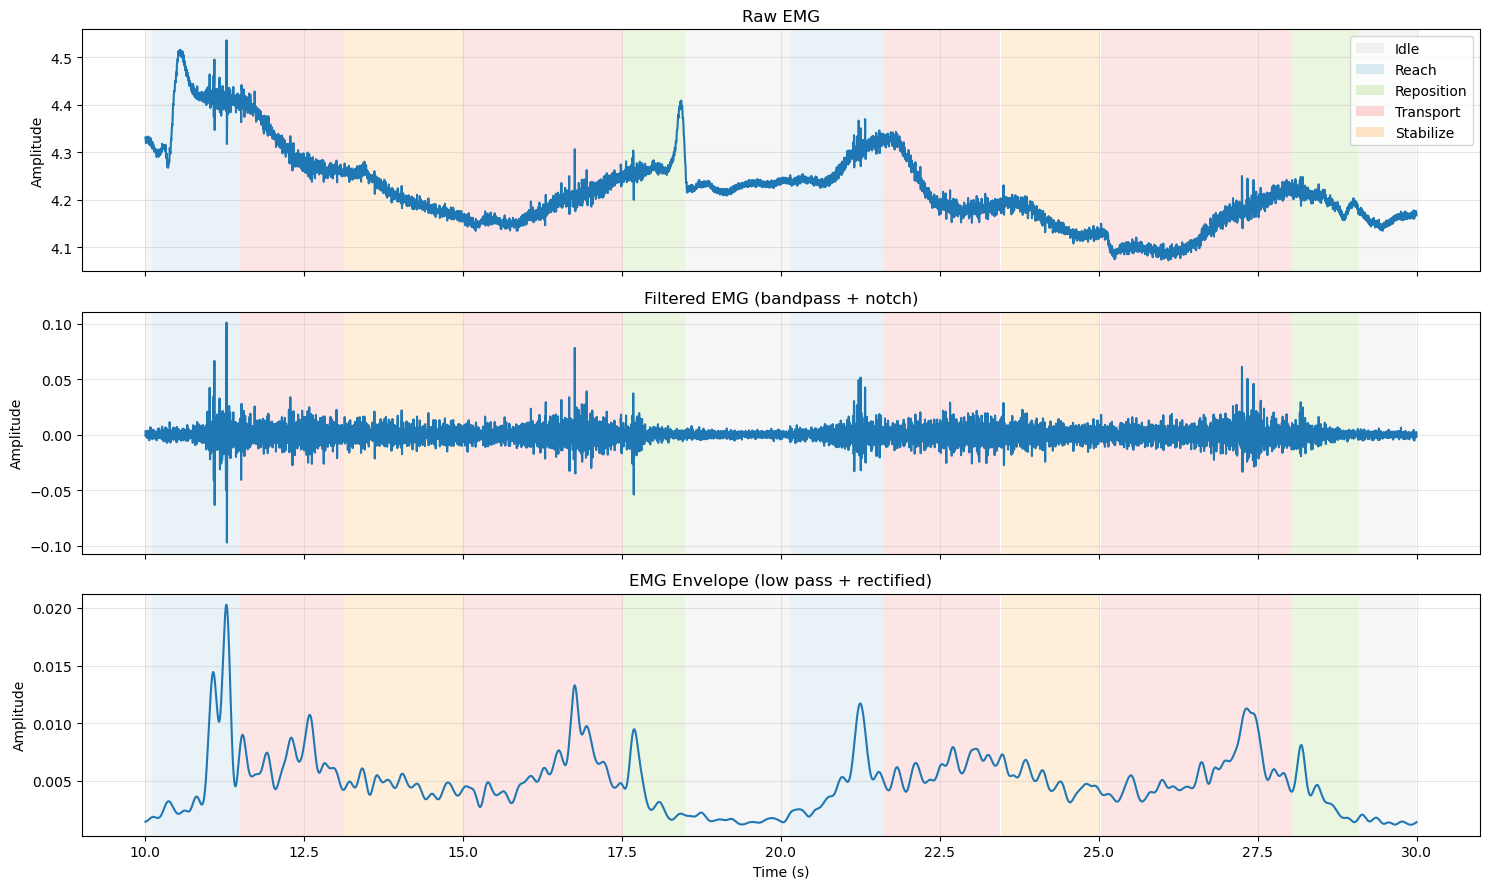

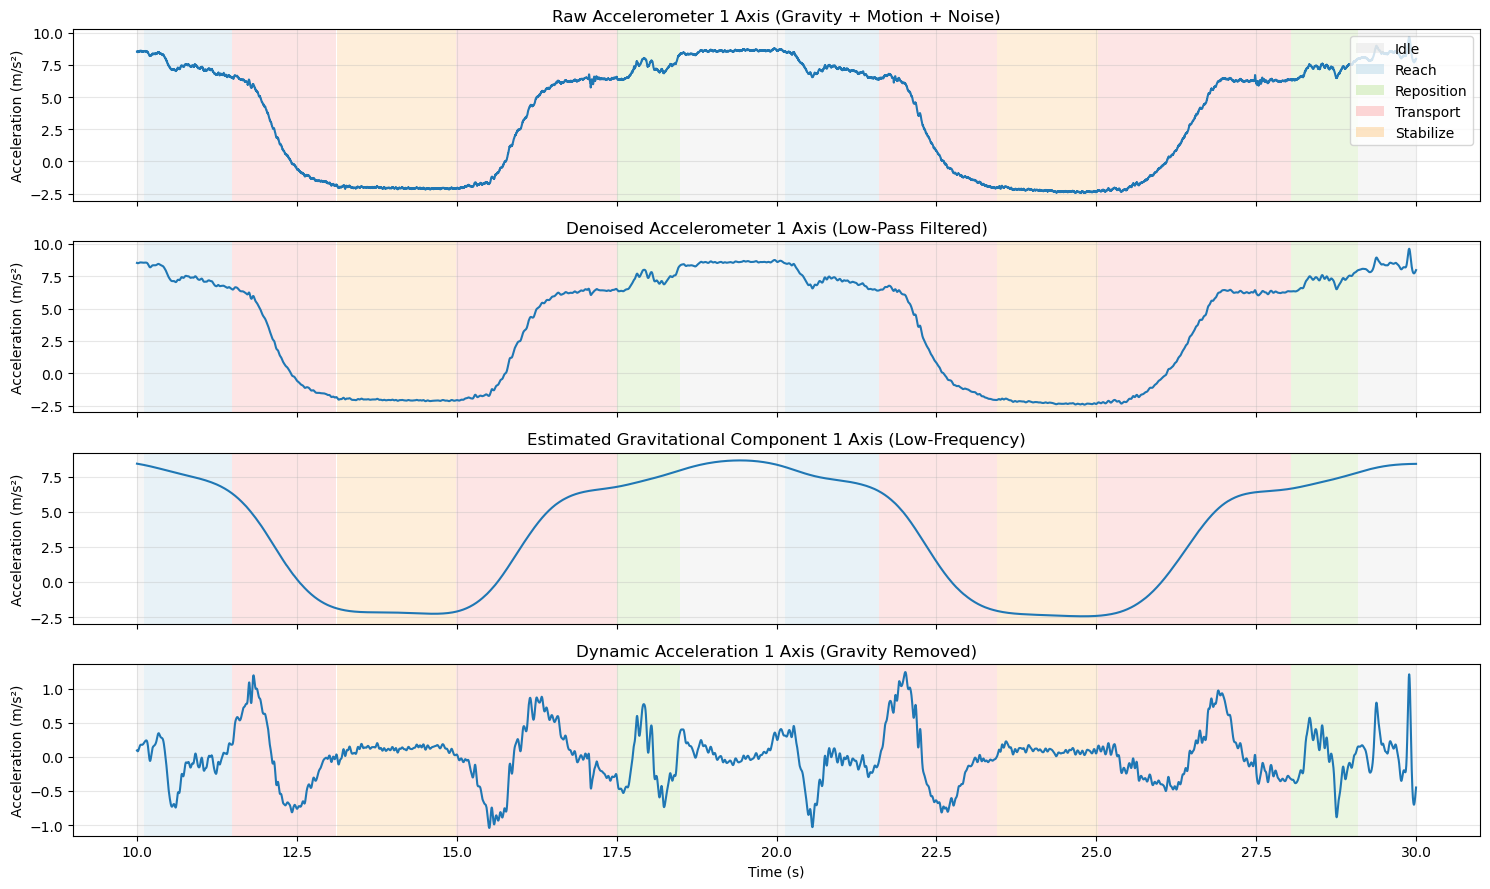

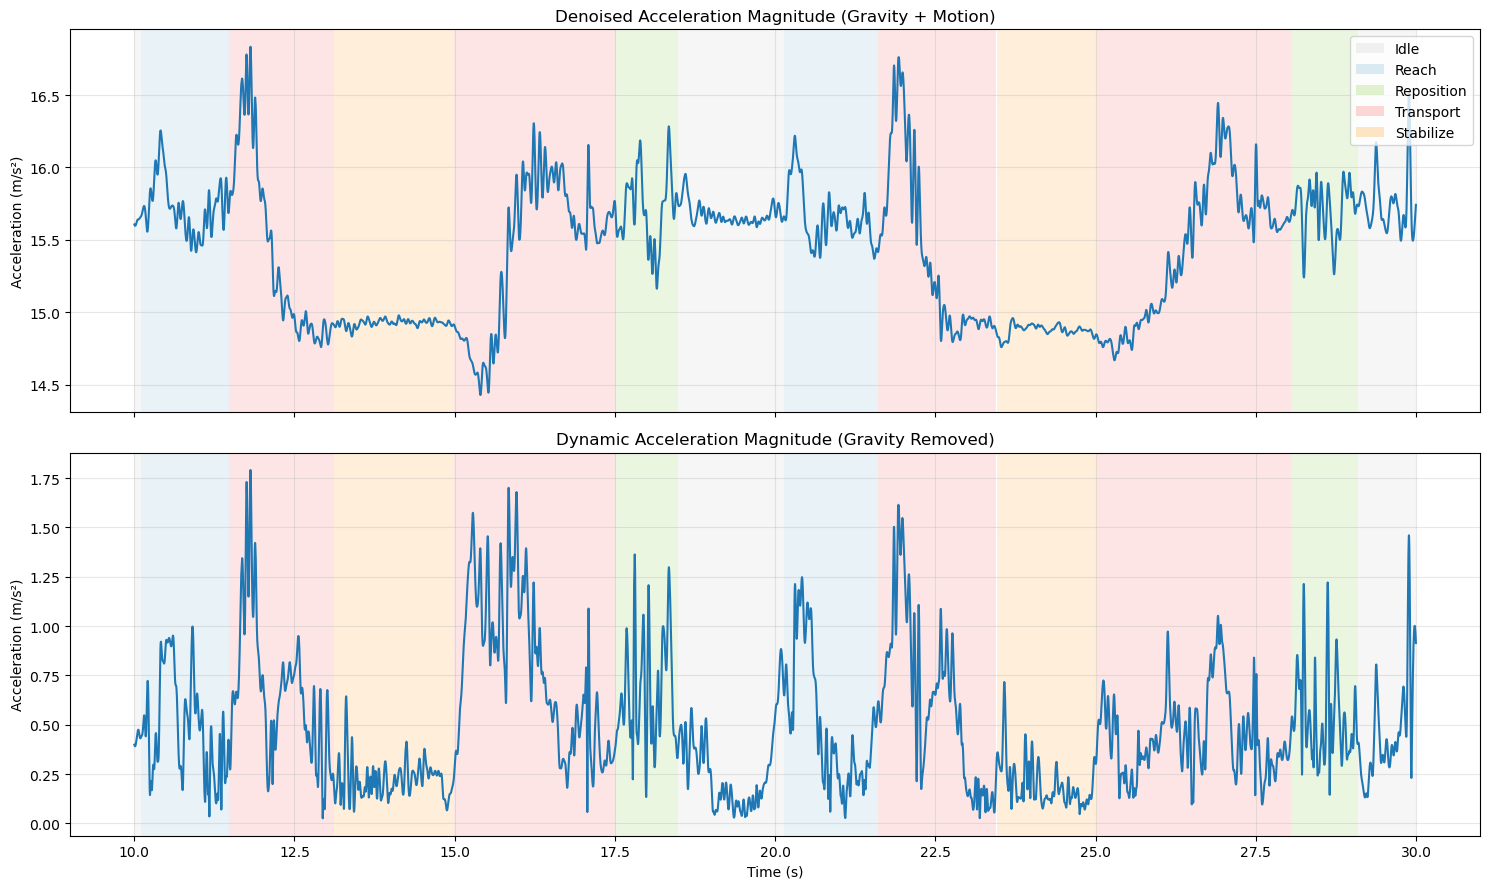

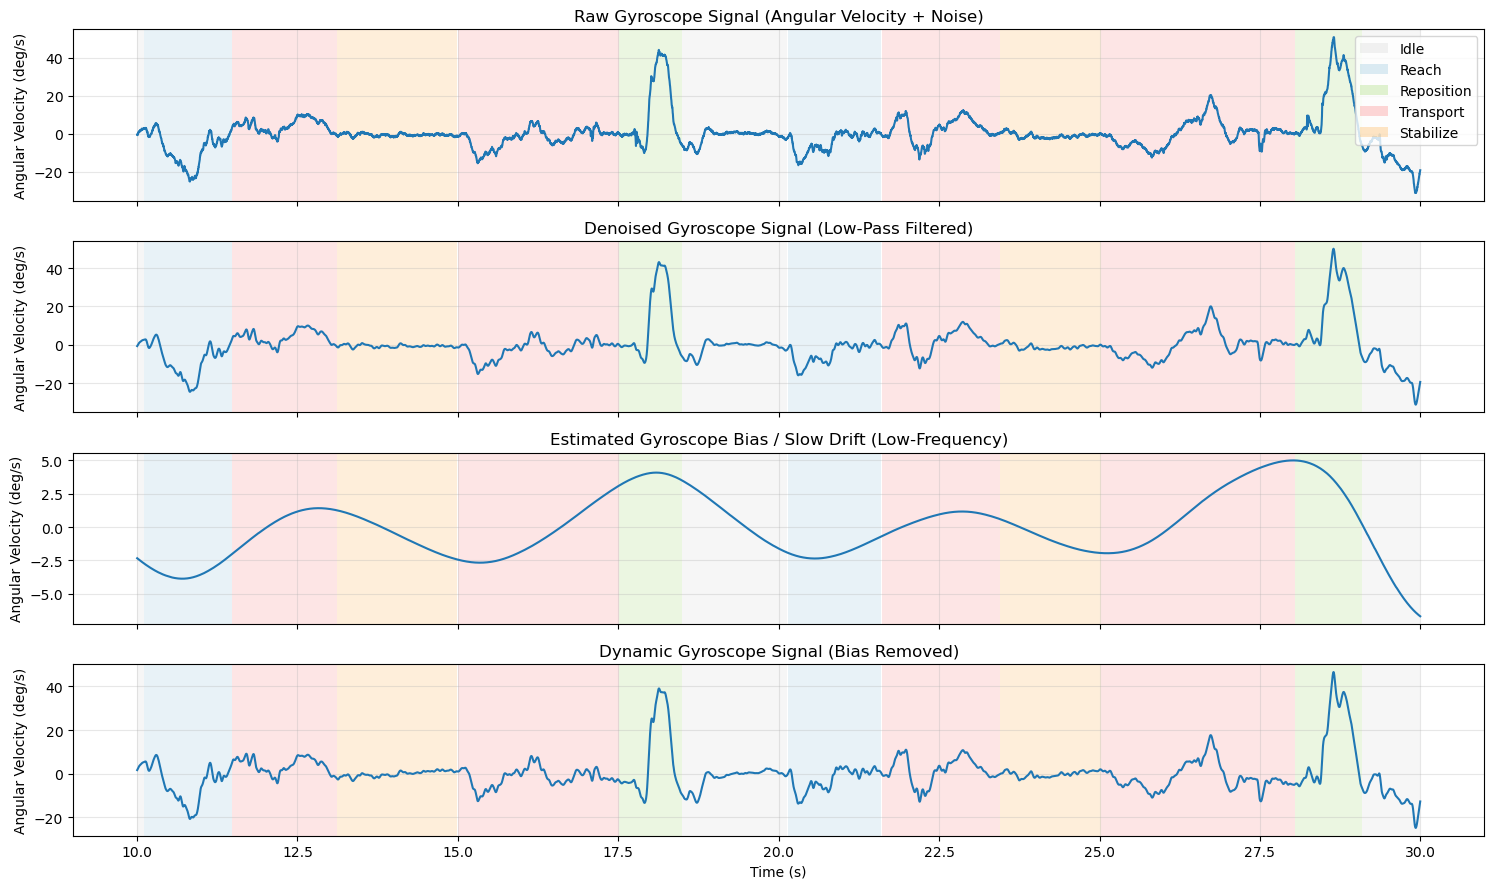

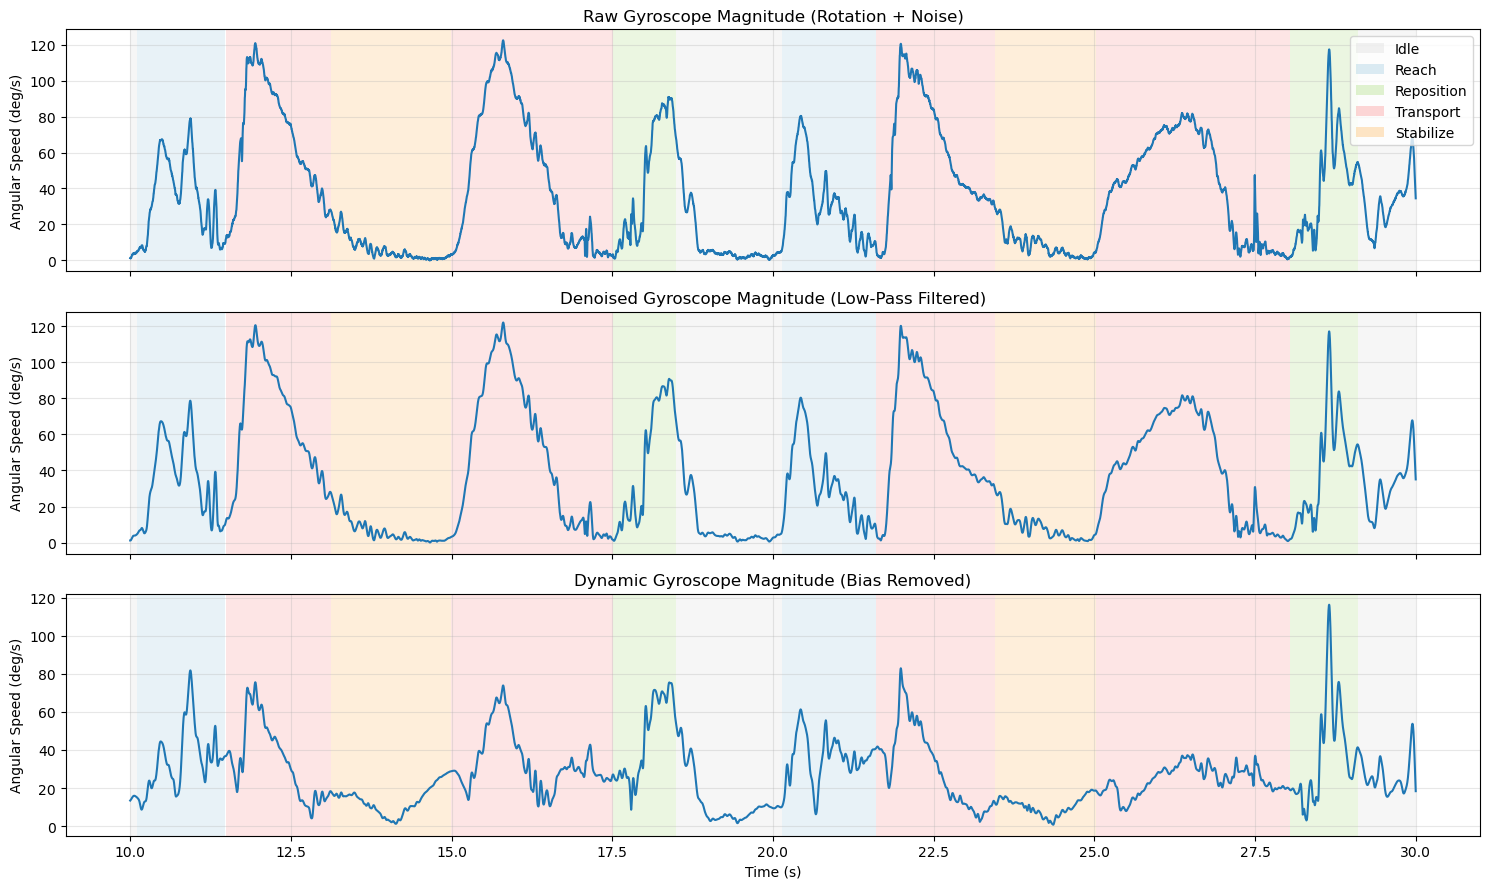

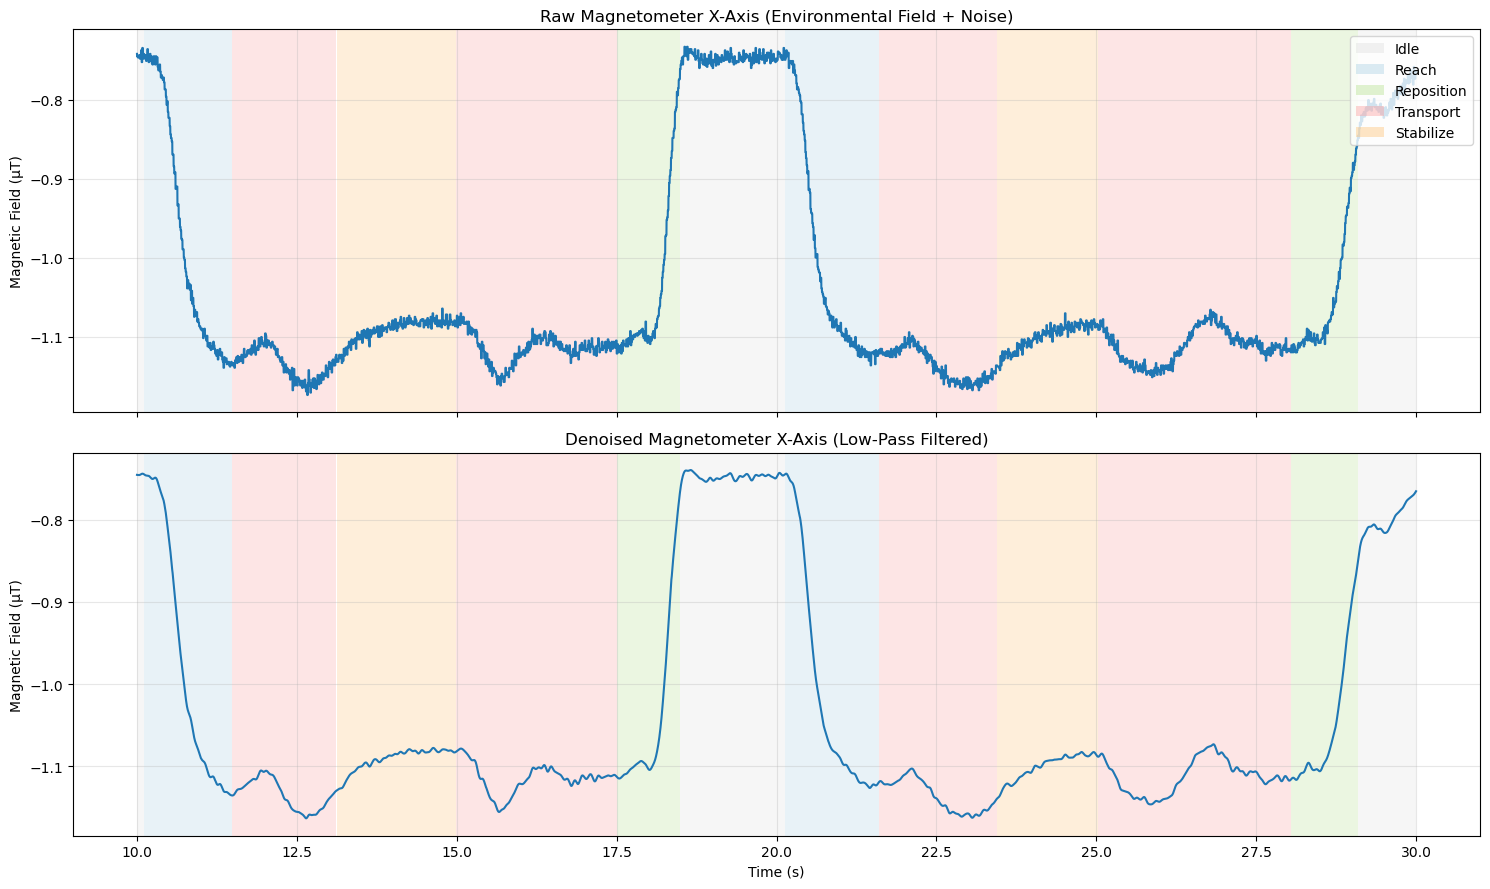

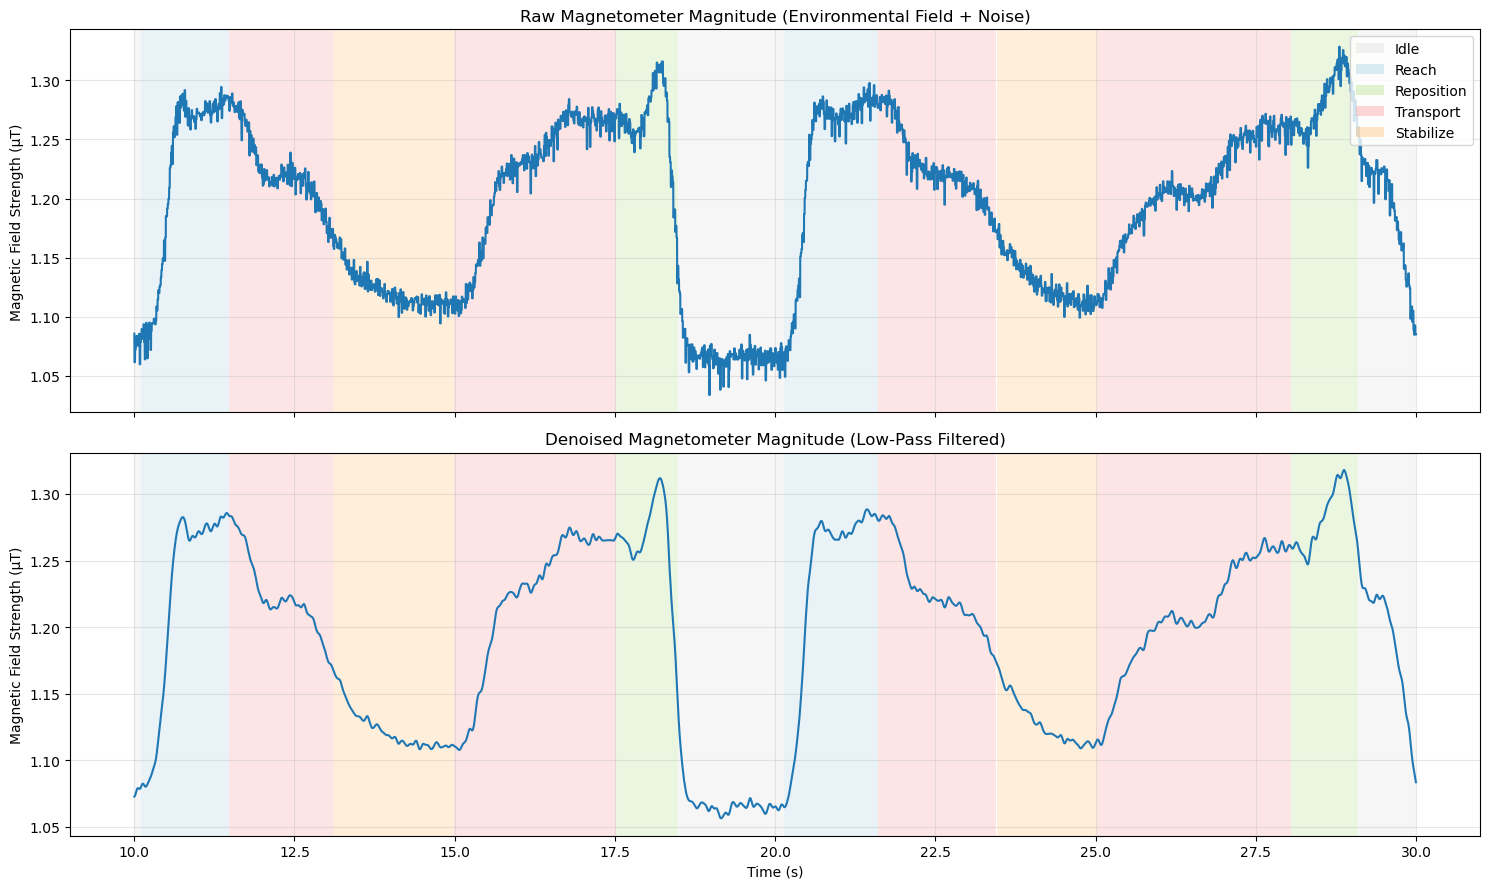

(<Figure size 1500x900 with 2 Axes>,
 array([<Axes: title={'center': 'Raw Magnetometer Magnitude (Environmental Field + Noise)'}, ylabel='Magnetic Field Strength (µT)'>,
        <Axes: title={'center': 'Denoised Magnetometer Magnitude (Low-Pass Filtered)'}, xlabel='Time (s)', ylabel='Magnetic Field Strength (µT)'>],
       dtype=object))

In [152]:
primitive_colors = {
    "Idle":       "#DDDDDD",
    "Reach":      "#A6CEE3",
    "Reposition": "#B2DF8A",
    "Transport":  "#FB9A99",
    "Stabilize":  "#FDBF6F",
}

df = full_df

# 1) EMG (raw / filtered / envelope)
plot_signals_with_primitives(
    df,
    panels=[
        {"col": "A5F2_EMG1",          "title": "Raw EMG"},
        {"col": "A5F2_EMG1_FILTERED", "title": "Filtered EMG (bandpass + notch)"},
        {"col": "A5F2_EMG1_ENV",      "title": "EMG Envelope (low pass + rectified)"},
    ],
    primitive_colors=primitive_colors,
    t_start=10, t_end=30,
    figsize=(15, 9),
    y_label="Amplitude",
    savepath="./emg_visual.png",
)

# 2) Accel axis (raw / denoised / grav / dyn)
plot_signals_with_primitives(
    df,
    panels=[
        {"col": "A5F2_AccelY",          "title": "Raw Accelerometer 1 Axis (Gravity + Motion + Noise)"},
        {"col": "A5F2_AccelY_DENOISED", "title": "Denoised Accelerometer 1 Axis (Low-Pass Filtered)"},
        {"col": "A5F2_AccelY_GRAV",     "title": "Estimated Gravitational Component 1 Axis (Low-Frequency)"},
        {"col": "A5F2_AccelY_DYN",      "title": "Dynamic Acceleration 1 Axis (Gravity Removed)"},
    ],
    primitive_colors=primitive_colors,
    t_start=10.0, t_end=30.0,
    figsize=(15, 9),
    y_label="Acceleration (m/s²)",
    savepath="./accel_axis_visual.png",
)

# 3) Accel magnitude (denoised / dynamic)
plot_signals_with_primitives(
    df,
    panels=[
        {"col": "A5F2_AccelMag_DENOISED", "title": "Denoised Acceleration Magnitude (Gravity + Motion)"},
        {"col": "A5F2_AccelMag_DYN",      "title": "Dynamic Acceleration Magnitude (Gravity Removed)"},
    ],
    primitive_colors=primitive_colors,
    t_start=10.0, t_end=30.0,
    figsize=(15, 9),
    y_label="Acceleration (m/s²)",
    savepath="./accel_mag_visual.png",
)

# 4) Gyro axis (raw / denoised / bias / dyn)
plot_signals_with_primitives(
    df,
    panels=[
        {"col": "A5F2_GyroX",          "title": "Raw Gyroscope Signal (Angular Velocity + Noise)"},
        {"col": "A5F2_GyroX_DENOISED", "title": "Denoised Gyroscope Signal (Low-Pass Filtered)"},
        {"col": "A5F2_GyroX_BIAS",     "title": "Estimated Gyroscope Bias / Slow Drift (Low-Frequency)"},
        {"col": "A5F2_GyroX_DYN",      "title": "Dynamic Gyroscope Signal (Bias Removed)"},
    ],
    primitive_colors=primitive_colors,
    t_start=10.0, t_end=30.0,
    figsize=(15, 9),
    y_label="Angular Velocity (deg/s)",
    savepath="./gyro_axis_visual.png",
)

# 5) Gyro magnitude (raw / denoised / dynamic)
plot_signals_with_primitives(
    df,
    panels=[
        {"col": "A5F2_GyroMag",          "title": "Raw Gyroscope Magnitude (Rotation + Noise)"},
        {"col": "A5F2_GyroMag_DENOISED", "title": "Denoised Gyroscope Magnitude (Low-Pass Filtered)"},
        {"col": "A5F2_GyroMag_DYN",      "title": "Dynamic Gyroscope Magnitude (Bias Removed)"},
    ],
    primitive_colors=primitive_colors,
    t_start=10.0, t_end=30.0,
    figsize=(15, 9),
    y_label="Angular Speed (deg/s)",
    savepath="./gyro_mag_visual.png",
)

# 6) Mag axis (raw / denoised)
plot_signals_with_primitives(
    df,
    panels=[
        {"col": "A5F2_MagX",          "title": "Raw Magnetometer X-Axis (Environmental Field + Noise)"},
        {"col": "A5F2_MagX_DENOISED", "title": "Denoised Magnetometer X-Axis (Low-Pass Filtered)"},
    ],
    primitive_colors=primitive_colors,
    t_start=10.0, t_end=30.0,
    figsize=(15, 9),
    y_label="Magnetic Field (µT)",
    savepath="./mag_axis_visual.png",
)

# 7) Mag magnitude (raw / denoised)
plot_signals_with_primitives(
    df,
    panels=[
        {"col": "A5F2_MagnetMag",          "title": "Raw Magnetometer Magnitude (Environmental Field + Noise)"},
        {"col": "A5F2_MagnetMag_DENOISED", "title": "Denoised Magnetometer Magnitude (Low-Pass Filtered)"},
    ],
    primitive_colors=primitive_colors,
    t_start=10.0, t_end=30.0,
    figsize=(15, 9),
    y_label="Magnetic Field Strength (µT)",
    savepath="./mag_mag_visual.png",
)
